In [5]:
import warnings
import pandas as pd
import datetime, pytz
from persiantools.jdatetime import JalaliDate
from persiantools.jdatetime import JalaliDateTime
import jalali
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [6]:
data=pd.read_excel(r'C:\Users\asus\Desktop\New Proje\Feeder.xlsx','Sheet1')
data.head()

,date,A,B,C,AEns,Unnamed: 5,datemonth,AEnsM,Unnamed: 8,Month
0,1393/01/01,0,0.0,0.0,0.0,NaN,1393/01,22119.256899,NaN,1393/01
1,1393/01/02,0,1.0,0.0,0.0,NaN,1393/02,5920.582593,NaN,1393/01
2,1393/01/03,0,1.0,0.0,0.0,NaN,1393/03,2820.122762,NaN,1393/01
3,1393/01/04,0,0.0,0.0,0.0,NaN,1393/04,1412.176449,NaN,1393/01
4,1393/01/05,0,0.0,0.0,0.0,NaN,1393/05,23714.941810,NaN,1393/01


In [7]:
datecols = ['date']
data[datecols] = data[datecols].applymap(lambda x: 
                                     JalaliDateTime(int(x[:4]),
                                                    int(x[5:7]),
                                                    int(x[8:10]),
                                                    
                                                    ).to_gregorian() if isinstance(x,str) else None)

In [8]:
cols = ['B', 'C','A', 'Unnamed: 5','datemonth','AEnsM','Unnamed: 8','Month']
data.drop(cols, axis=1, inplace=True)
data = data.sort_values('date')
#data.isnull().sum()

In [9]:
data = data.groupby('date')['AEns'].sum().reset_index()

In [10]:
data = data.set_index('date')
data.index

DatetimeIndex(['2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
               '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
               '2014-03-29', '2014-03-30',
               ...
               '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-20'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

In [13]:
y = data['AEns']

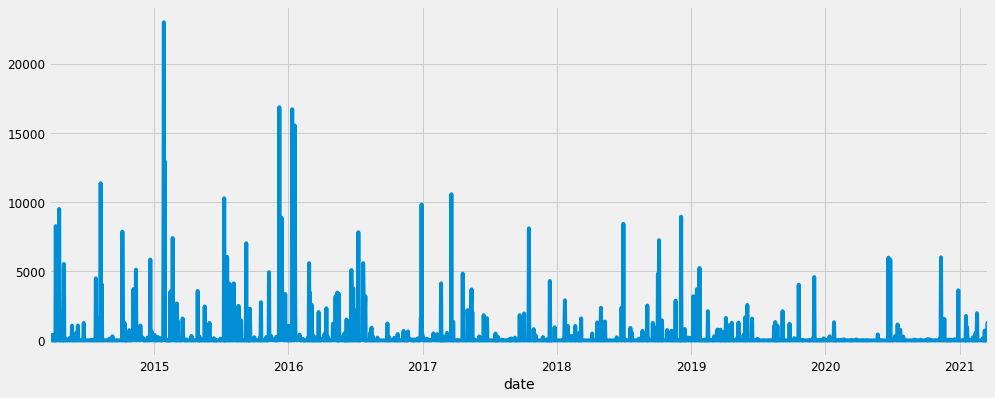

In [14]:
y.plot(figsize=(15, 6))
plt.show()

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit() 
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

IndentationError: unexpected unindent (<ipython-input-16-b281b4cca43b>, line 9)

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0919      0.020      4.672      0.000       0.053       0.130
ma.L1         -0.9994      0.029    -34.406      0.000      -1.056      -0.943
ar.S.L12      -0.5221      0.008    -68.061      0.000      -0.537      -0.507
sigma2      3.592e+06   9.75e+04     36.838      0.000     3.4e+06    3.78e+06


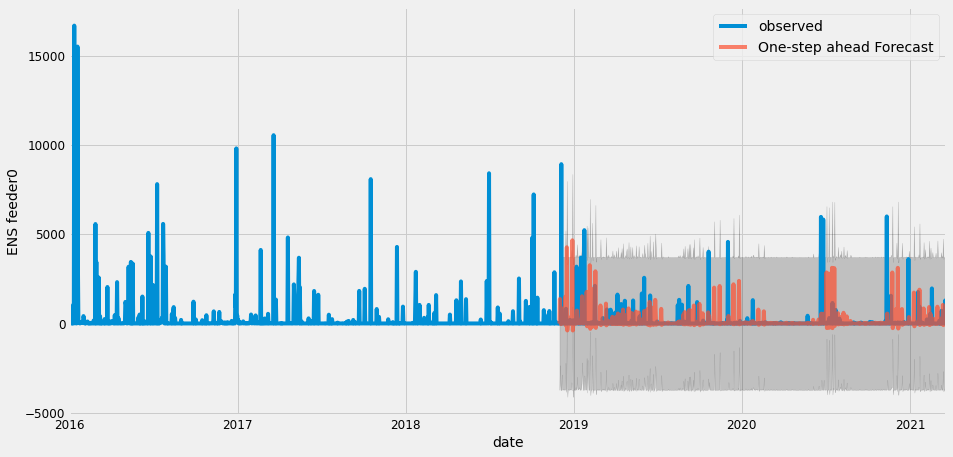

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2018-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('ENS feeder0')
plt.legend()
plt.show()

In [19]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-12-15 10:46:00':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 514690.67


In [20]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 717.42
